In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import ImageEnhance, ImageOps
from mtcnn import MTCNN
from mtcnn.mtcnn import MTCNN
import cv2
import random
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm


In [2]:
data_dir = "data"
categories = ["criminal", "non-criminal"]

# Detector
detector = MTCNN()

Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\MuhammadAulia\miniconda3\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\MuhammadAulia\miniconda3\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\MuhammadAulia\miniconda3\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


## Show Data Image (Criminal & Non-criminal)

In [3]:
def show_all_data(categories, max_per_cat=5):
    all_images = []
    labels = []

    for category in categories:
        folder = os.path.join(data_dir, category)

        img_files = []
        for root, _, files in os.walk(folder):
            for f in files:
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_files.append(os.path.join(root, f))

        # Random sample
        img_files = random.sample(img_files, min(max_per_cat, len(img_files)))

        # Append to list
        all_images.extend(img_files)
        labels.extend([category] * len(img_files))

    # Show horizontally
    plt.figure(figsize=(20, 5))
    for idx, (img_path, label) in enumerate(zip(all_images, labels)):
        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            continue
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        plt.subplot(1, len(all_images), idx+1)
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")

    plt.suptitle("All Categories - Original Images", fontsize=16)
    plt.tight_layout()
    plt.show()

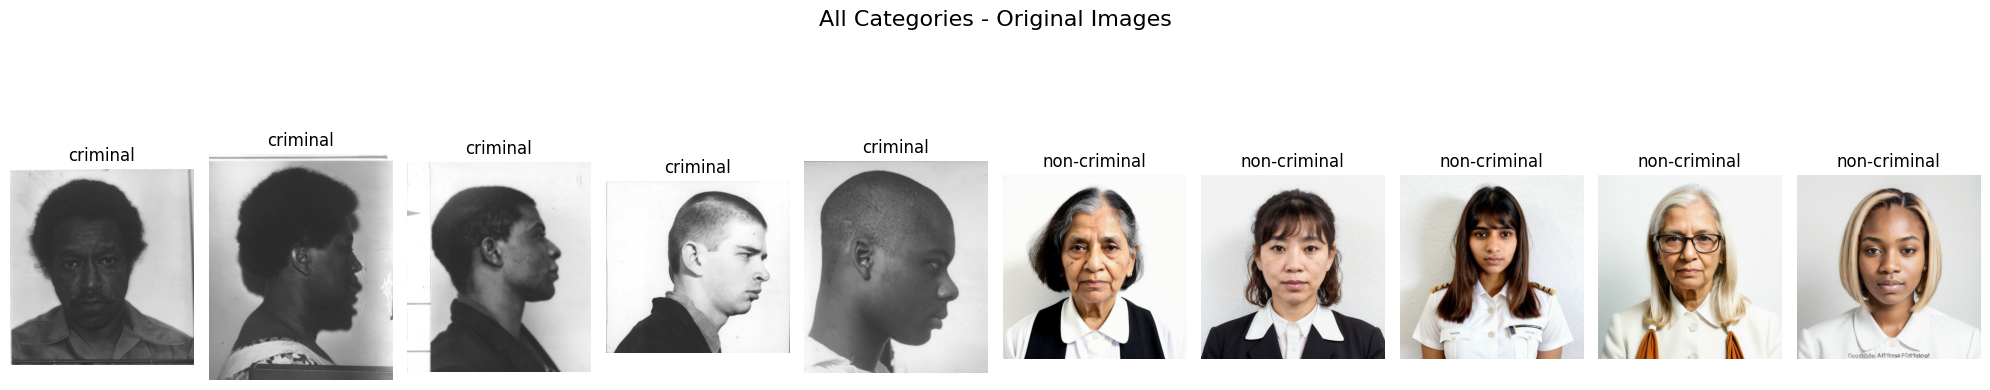

In [4]:
show_all_data(categories, max_per_cat=5)

## Show MTCNN Results (Criminal & Non-criminal)

In [5]:
def show_all_data_mtcnn(categories, max_per_cat=5):
    all_images = []
    labels = []

    for category in categories:
        folder = os.path.join(data_dir, category)

        img_files = []
        for root, _, files in os.walk(folder):
            for f in files:
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_files.append(os.path.join(root, f))

        img_files = random.sample(img_files, min(max_per_cat, len(img_files)))

        # Append to list
        all_images.extend(img_files)
        labels.extend([category] * len(img_files))

    # Show horizontally
    plt.figure(figsize=(20, 5))
    for idx, (img_path, label) in enumerate(zip(all_images, labels)):
        image_bgr = cv2.imread(img_path)
        if image_bgr is None:
            continue
        image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # Detect faces
        results = detector.detect_faces(image)

        # Draw bounding boxes
        for res in results:
            x, y, w, h = res['box']
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
            confidence = res['confidence']
            cv2.putText(image, f"{confidence:.2f}", (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

        plt.subplot(1, len(all_images), idx+1)
        plt.imshow(image)
        plt.title(f"{label}\nFaces: {len(results)}")
        plt.axis("off")

        print(f"File: {os.path.basename(img_path)} | Category: {label} | Faces detected: {len(results)}")

    plt.suptitle("All Categories - MTCNN Results", fontsize=16)
    plt.tight_layout()
    plt.show()

File: 00084_2_F.png | Category: criminal | Faces detected: 1
File: 00059_1_F.png | Category: criminal | Faces detected: 1
File: 00007_2_R.png | Category: criminal | Faces detected: 1
File: 00009_2_F.png | Category: criminal | Faces detected: 1
File: 00023_2_F.png | Category: criminal | Faces detected: 1
File: S95924864-GM-A18-EEA-T14-S1-LH-C1-I0019-F00.png | Category: non-criminal | Faces detected: 1
File: S78988072-GM-A54-EAF-T14-S1-LH-C1-I0029-F00.png | Category: non-criminal | Faces detected: 1
File: S86418004-GF-A49-EEA-T10-S1-LH-C1-I0041-F00.png | Category: non-criminal | Faces detected: 1
File: S40535953-GF-A44-EAS-T14-S1-LH-C1-I0030-F00.png | Category: non-criminal | Faces detected: 1
File: S94433945-GF-A84-EIA-T14-S1-LH-C1-I0032-F00.png | Category: non-criminal | Faces detected: 1


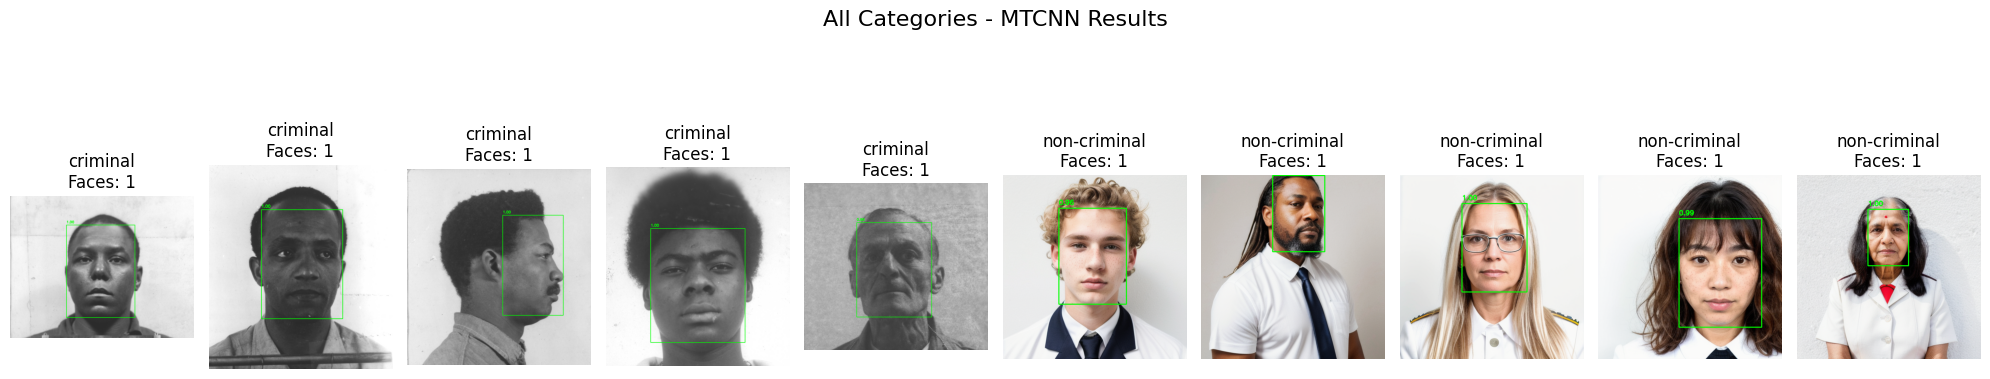

In [6]:
show_all_data_mtcnn(categories, max_per_cat=5)

In [7]:
def process_mtcnn_preprocessing(categories, target_size=(64,64)):
    images = []
    labels = []

    for label, category in enumerate(categories):
        folder = os.path.join(data_dir, category)

        img_files = []
        for root, _, files in os.walk(folder):
            for f in files:
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_files.append(os.path.join(root, f))

        # Loop images
        for img_path in img_files:
            image_bgr = cv2.imread(img_path)
            if image_bgr is None:
                continue
            image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

            # Detect faces
            results = detector.detect_faces(image)

            # Only keep if exactly 1 face detected
            if len(results) == 1:
                x, y, w, h = results[0]['box']
                face = image[y:y+h, x:x+w]

                # Resize + grayscale
                face_resized = cv2.resize(face, target_size)
                face_gray = cv2.cvtColor(face_resized, cv2.COLOR_RGB2GRAY)

                images.append(face_gray)
                labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [8]:
images, labels = process_mtcnn_preprocessing(categories, target_size=(64,64))
print(f"✅ Total preprocessed images: {len(images)}")

✅ Total preprocessed images: 1739


## Preprocessing

In [9]:
def show_preprocessed_samples(images, labels, categories, n=10):
    plt.figure(figsize=(15,3))
    indices = np.random.choice(len(images), min(n, len(images)), replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(1, n, i+1)
        plt.imshow(images[idx].squeeze(), cmap="gray")
        plt.title(categories[labels[idx]])
        plt.axis("off")
    plt.show()

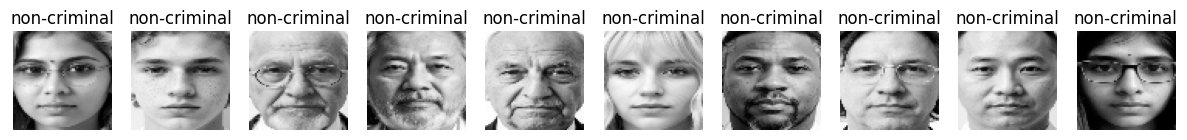

In [10]:
# Show random samples
show_preprocessed_samples(images, labels, categories, n=10)

## Normalize & One-hot Encode

In [11]:
# =========================================
# Dataset Asli (hasil preprocessing MTCNN)
# =========================================
print(f"Data asli: {images.shape}, Labels: {len(labels)}")

# Normalisasi & reshape
images = images.astype("float32") / 255.0
images = np.expand_dims(images, axis=-1)

# One-hot encode labels
num_classes = len(categories)
labels_cat = to_categorical(labels, num_classes=num_classes)

Data asli: (1739, 64, 64), Labels: 1739


## Training Model (CNN) -> 70:30

In [12]:
# Split Data (Train/Test) 70:30
X_train_70, X_test_30, y_train_70, y_test_30 = train_test_split(
    images, labels_cat,
    test_size=0.3, random_state=42, stratify=labels
)

print(f"Train shape (70%): {X_train_70.shape}, Test shape (30%): {X_test_30.shape}")

Train shape (70%): (1217, 64, 64, 1), Test shape (30%): (522, 64, 64, 1)


In [13]:
model_70 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(64,64,1)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_70.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

model_70.summary()

c:\Users\MuhammadAulia\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,882 (2.60 MB)

 Trainable params: 682,882 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history_70 = model_70.fit(
    X_train_70, y_train_70,
    validation_data=(X_test_30, y_test_30),
    epochs=50,
    batch_size=32,
    verbose=1
)

loss_70, acc_70 = model_70.evaluate(X_test_30, y_test_30, verbose=0)
print(f"✅ Test Accuracy (70:30): {acc_70:.4f}")

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8036 - loss: 0.4230 - val_accuracy: 0.8142 - val_loss: 0.2686
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9285 - loss: 0.1852 - val_accuracy: 0.9617 - val_loss: 0.1111
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9680 - loss: 0.0923 - val_accuracy: 0.9713 - val_loss: 0.0832
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9704 - loss: 0.0815 - val_accuracy: 0.9732 - val_loss: 0.0856
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9836 - loss: 0.0547 - val_accuracy: 0.9770 - val_loss: 0.0520
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9729 - loss: 0.0715 - val_accuracy: 0.9808 - val_loss: 0.0590
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9860 - loss: 0.0473 - val_accuracy: 0.9828 - val_loss: 0.0403
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9869 - loss: 0.0423 - val_accuracy: 0.9751 - v

## Model Evaluation

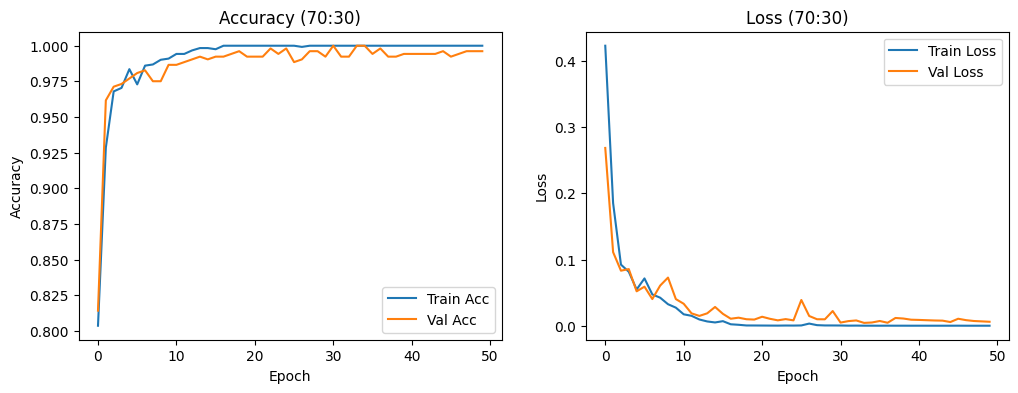

In [15]:
# === Visualization (70:30) ===
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_70.history["accuracy"], label="Train Acc")
plt.plot(history_70.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy (70:30)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_70.history["loss"], label="Train Loss")
plt.plot(history_70.history["val_loss"], label="Val Loss")
plt.title("Loss (70:30)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


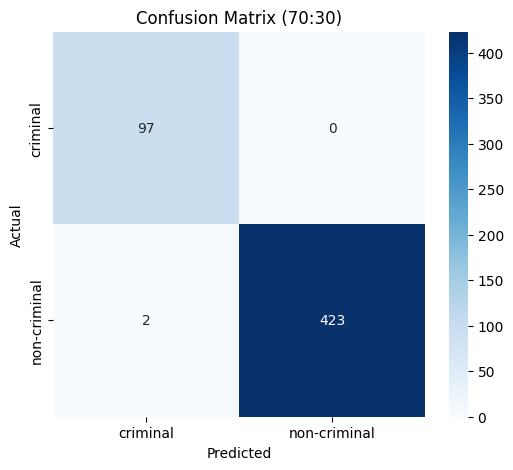

📊 Classification Report (70:30):

              precision    recall  f1-score   support

    criminal       0.98      1.00      0.99        97
non-criminal       1.00      1.00      1.00       425

    accuracy                           1.00       522
   macro avg       0.99      1.00      0.99       522
weighted avg       1.00      1.00      1.00       522



In [16]:
# Confusion Matrix
y_pred_probs_70 = model_70.predict(X_test_30)
y_pred_70 = np.argmax(y_pred_probs_70, axis=1)
y_true_70 = np.argmax(y_test_30, axis=1)

cm_70 = confusion_matrix(y_true_70, y_pred_70)

plt.figure(figsize=(6,5))
sns.heatmap(cm_70, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (70:30)")
plt.show()

print("📊 Classification Report (70:30):\n")
print(classification_report(y_true_70, y_pred_70, target_names=categories))

## Training Model (CNN) -> 80:20

In [17]:
X_train_80, X_test_20, y_train_80, y_test_20 = train_test_split(
    images, labels_cat, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train shape (80%): {X_train_80.shape}, Test shape (20%): {X_test_20.shape}")

Train shape (80%): (1391, 64, 64, 1), Test shape (20%): (348, 64, 64, 1)


In [18]:
model_80 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(64,64,1)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_80.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

model_80.summary()

c:\Users\MuhammadAulia\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,882 (2.60 MB)

 Trainable params: 682,882 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history_80 = model_80.fit(
    X_train_80, y_train_80,
    validation_data=(X_test_20, y_test_20),
    epochs=50,
    batch_size=32,
    verbose=1
)

loss_80, acc_80 = model_80.evaluate(X_test_20, y_test_20, verbose=0)
print(f"✅ Test Accuracy (80:20): {acc_80:.4f}")

Epoch 1/50


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8231 - loss: 0.3584 - val_accuracy: 0.9224 - val_loss: 0.2236
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9569 - loss: 0.1557 - val_accuracy: 0.9655 - val_loss: 0.1101
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9727 - loss: 0.0809 - val_accuracy: 0.9540 - val_loss: 0.1349
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9813 - loss: 0.0495 - val_accuracy: 0.9914 - val_loss: 0.0379
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9792 - loss: 0.0521 - val_accuracy: 0.9799 - val_loss: 0.0429
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9856 - loss: 0.0333 - val_accuracy: 0.9828 - val_loss: 0.0337
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9863 - loss: 0.0414 - val_accuracy: 0.9885 - val_loss: 0.0373
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9899 - loss: 0.0230 - val_accuracy: 0.9828 - val_loss: 0.

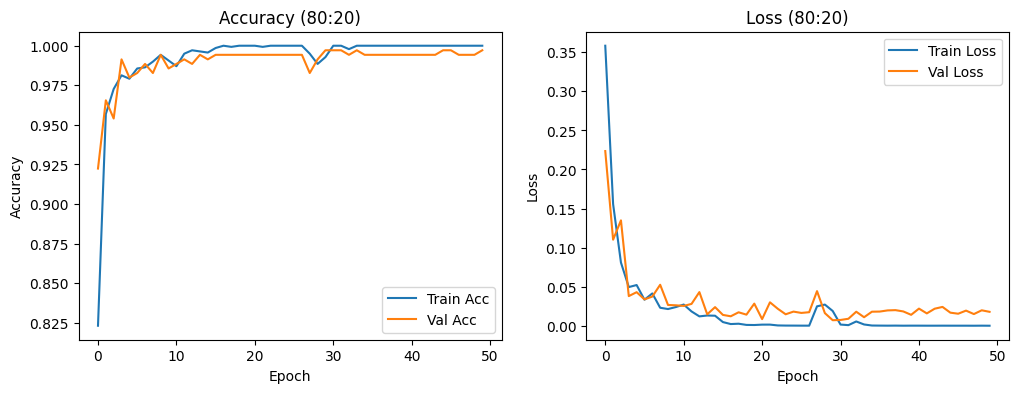

In [20]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_80.history["accuracy"], label="Train Acc")
plt.plot(history_80.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy (80:20)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_80.history["loss"], label="Train Loss")
plt.plot(history_80.history["val_loss"], label="Val Loss")
plt.title("Loss (80:20)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


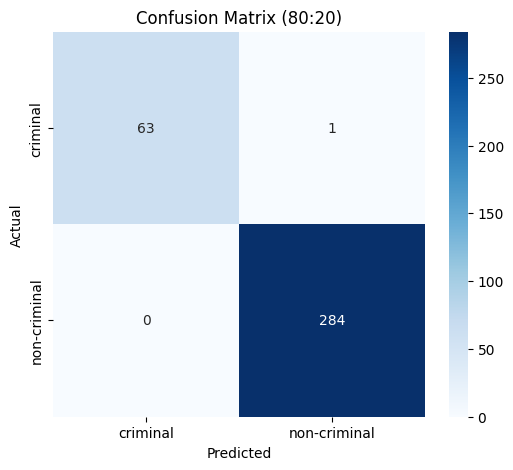

In [21]:
# Confusion Matrix
y_pred_probs_80 = model_80.predict(X_test_20)
y_pred_80 = np.argmax(y_pred_probs_80, axis=1)
y_true_80 = np.argmax(y_test_20, axis=1)

cm_80 = confusion_matrix(y_true_80, y_pred_80)

plt.figure(figsize=(6,5))
sns.heatmap(cm_80, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (80:20)")
plt.show()

In [22]:
print("📊 Classification Report (80:20):\n")
print(classification_report(y_true_80, y_pred_80, target_names=categories))

📊 Classification Report (80:20):

              precision    recall  f1-score   support

    criminal       1.00      0.98      0.99        64
non-criminal       1.00      1.00      1.00       284

    accuracy                           1.00       348
   macro avg       1.00      0.99      1.00       348
weighted avg       1.00      1.00      1.00       348



## Training Model (CNN) -> 90:10

In [23]:
X_train_90, X_test_10, y_train_90, y_test_10 = train_test_split(
    images, labels_cat, test_size=0.2, random_state=42, stratify=labels
)

print(f"Train shape (90%): {X_train_90.shape}, Test shape (10%): {X_test_10.shape}")

Train shape (90%): (1391, 64, 64, 1), Test shape (10%): (348, 64, 64, 1)


In [24]:
model_90 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(64,64,1)),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model_90.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

model_90.summary()

c:\Users\MuhammadAulia\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,882 (2.60 MB)

 Trainable params: 682,882 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history_90 = model_90.fit(
    X_train_90, y_train_90,
    validation_data=(X_test_10, y_test_10),
    epochs=50,
    batch_size=32,
    verbose=1
)

loss_90, acc_90 = model_90.evaluate(X_test_10, y_test_10, verbose=0)
print(f"✅ Test Accuracy (90:10): {acc_90:.4f}")

Epoch 1/50


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8375 - loss: 0.3437 - val_accuracy: 0.9052 - val_loss: 0.2268
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9583 - loss: 0.1319 - val_accuracy: 0.9626 - val_loss: 0.1034
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9784 - loss: 0.0674 - val_accuracy: 0.9626 - val_loss: 0.1080
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9813 - loss: 0.0661 - val_accuracy: 0.9914 - val_loss: 0.0382
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9849 - loss: 0.0460 - val_accuracy: 0.9885 - val_loss: 0.0374
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9842 - loss: 0.0467 - val_accuracy: 0.9885 - val_loss: 0.0475
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9820 - loss: 0.0507 - val_accuracy: 0.9943 - val_loss: 0.0421
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9885 - loss: 0.0336 - val_accuracy: 0.9856 - val_loss: 0.

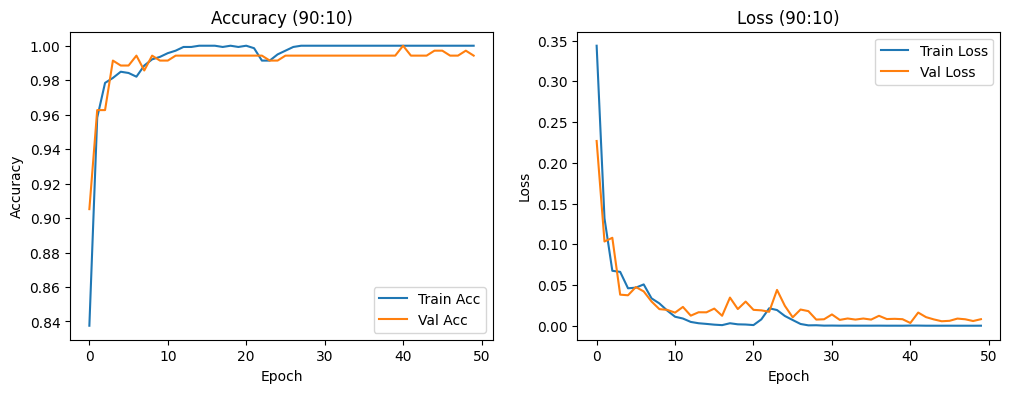

In [26]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_90.history["accuracy"], label="Train Acc")
plt.plot(history_90.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy (90:10)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_90.history["loss"], label="Train Loss")
plt.plot(history_90.history["val_loss"], label="Val Loss")
plt.title("Loss (90:10)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


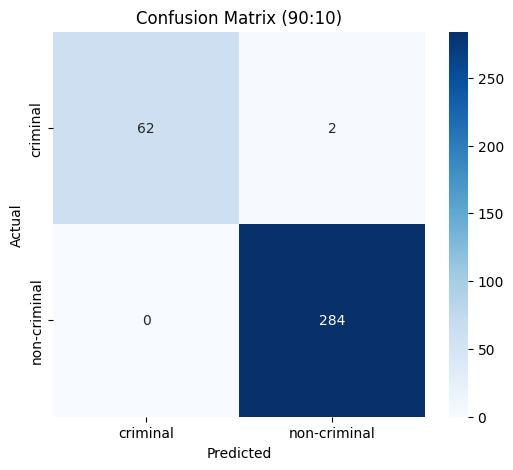

In [27]:
# Confusion Matrix
y_pred_probs_90 = model_90.predict(X_test_10)
y_pred_90 = np.argmax(y_pred_probs_90, axis=1)
y_true_90 = np.argmax(y_test_10, axis=1)

cm_90 = confusion_matrix(y_true_90, y_pred_90)

plt.figure(figsize=(6,5))
sns.heatmap(cm_90, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (90:10)")
plt.show()

In [28]:
# Classification Report
print("📊 Classification Report (90:10):\n")
print(classification_report(y_true_90, y_pred_90, target_names=categories))

📊 Classification Report (90:10):

              precision    recall  f1-score   support

    criminal       1.00      0.97      0.98        64
non-criminal       0.99      1.00      1.00       284

    accuracy                           0.99       348
   macro avg       1.00      0.98      0.99       348
weighted avg       0.99      0.99      0.99       348



## Save model

In [ ]:
# model.save("model/criminal_classifier_40Labels.h5")
# print("✅ Model saved!")

✅ Model saved!
